In [1]:
#!pip install transformers

#!pip install torch

In [2]:
from transformers import BertModel, BertTokenizerFast, BertForMaskedLM, BertForPreTraining

import torch

import pandas as pd

import numpy as np

2025-06-01 18:36:51.129880: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748803011.391423      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748803011.470352      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased", return_special_tokens_mask=True)


#  for MaskedLM allows MLM task
#model = BertForMaskedLM.from_pretrained("bert-base-uncased", output_hidden_states = True) 

# model for both MLM and NSP tasks
model = BertForPreTraining.from_pretrained("bert-base-uncased", output_hidden_states = True)

# does this properly import the weights???


# Set model to evaluation mode
model.eval()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertForPreTraining(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [4]:
#tokenizer

enc = tokenizer.encode("king")

print(enc)

print(tokenizer.decode(enc))

[101, 2332, 102]
[CLS] king [SEP]


In [5]:
test_sentence = "A kingfisher was spotted [MASK] the lake."

dec = tokenizer.encode(test_sentence)

print(dec)

print(tokenizer.decode(dec))

print(tokenizer.decode(dec[2]))
print(tokenizer.decode(dec[3]))
print(tokenizer.decode(dec[4]))

print(tokenizer.decode(dec[10]))

[101, 1037, 2332, 7529, 2121, 2001, 7282, 103, 1996, 2697, 1012, 102]
[CLS] a kingfisher was spotted [MASK] the lake. [SEP]
king
##fish
##er
.


# MLM

In [6]:
# create MLM data

df = pd.read_csv("/kaggle/input/test-clauses/embedded_clauses_variants.csv")

sent_type_dict = {}

for clause_type in df["Clause Type"].unique():
    sentences = df[df["Clause Type"] == clause_type]["Embedded Clause"].tolist()
    sent_type_dict[clause_type] = sentences


#print(sent_type_dict)

In [7]:
#print(df)

mlm_sent_type_dict = {}

for clause_type in sent_type_dict:
    mlm_sent_type_dict[clause_type] = [f"Mary X {x}" for x in sent_type_dict[clause_type]]




#for clause_type in clause_dict:
 #   clause_dict[clause_type] = [
  #      f"Mary X {sentence}" for sentence in clause_dict[clause_type]
   # ]
#print(mlm_sent_type_dict)

In [8]:
# target sentences

l1 = ["Ann X that Max read a book.", "Ann X that it was raining.", "Ann X that Max won the game"]

l2 = ["Ann X which book Max read.", "Ann X what time it was raining", "Ann X which dog won the game"]

mlm_sentences = [
    "The Eiffel Tower is located in [MASK].",
    "The Eiffel Tower is located in [MASK] [MASK].",
    "The Eiffel Tower is located in [MASK] [MASK] [MASK].",
    "Water boils at [MASK] degrees Celsius.",
    "Water appears [MASK] be boiling",
    "Water appears [MASK] [MASK] boiling"
]

In [9]:
# predict top_k tokens


def mlm_for_lists(sentence_list, top_k=5):
    predictions = []

    predictions_vector = []
    
    for sent_base in sentence_list:
        sent = sent_base.replace(" X ", " [MASK] ") # replace X with masked token
        inputs = tokenizer(sent, return_tensors="pt")
        
        mask_indices = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]


        with torch.no_grad():
            outputs = model(**inputs)
            mlm_logits = outputs.prediction_logits


        for mask_index in mask_indices:
            logits = mlm_logits[0, mask_index, :]
            top_k_ids = torch.topk(logits, top_k).indices #.tolist()
            top_k_tokens = tokenizer.convert_ids_to_tokens(top_k_ids)
        

            predictions += top_k_tokens #predicted_tokens
            
            
            token_embeddings = model.get_input_embeddings()(top_k_ids)  # shape: [top_k, hidden_dim]
            predictions_vector.append(token_embeddings)
       
    #print(f"Input: {sent}")
        #print(f"Predicted: {top_k_tokens}")
        #print()

    return predictions, predictions_vector



        

def pred_dict_maker(type_dict):
    pred_dict = {}
    embeddings_pred_dict = {}
 
    for key, value in type_dict.items():
        pred_dict[key], embeddings_pred_dict[key] = mlm_for_lists(value)
        

    return pred_dict, embeddings_pred_dict




In [10]:
pred_dict, embeddings_pred_dict = pred_dict_maker(mlm_sent_type_dict)

#print(pred_dict)

#print(embeddings_pred_dict)

#predictions_l1 = mlm_for_lists(l1)

#predictions_l2 = mlm_for_lists(l2)

#print(set(predictions_l1))

#print(set(predictions_l2))

# the different predictions are single tokens, and cannot be uniformed via .tokenize()


## PCA

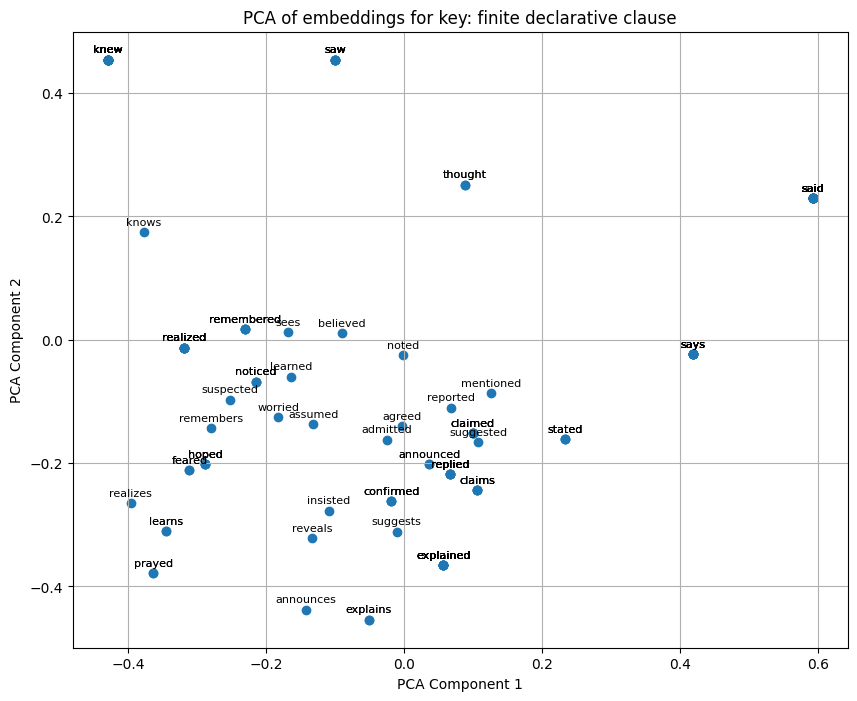

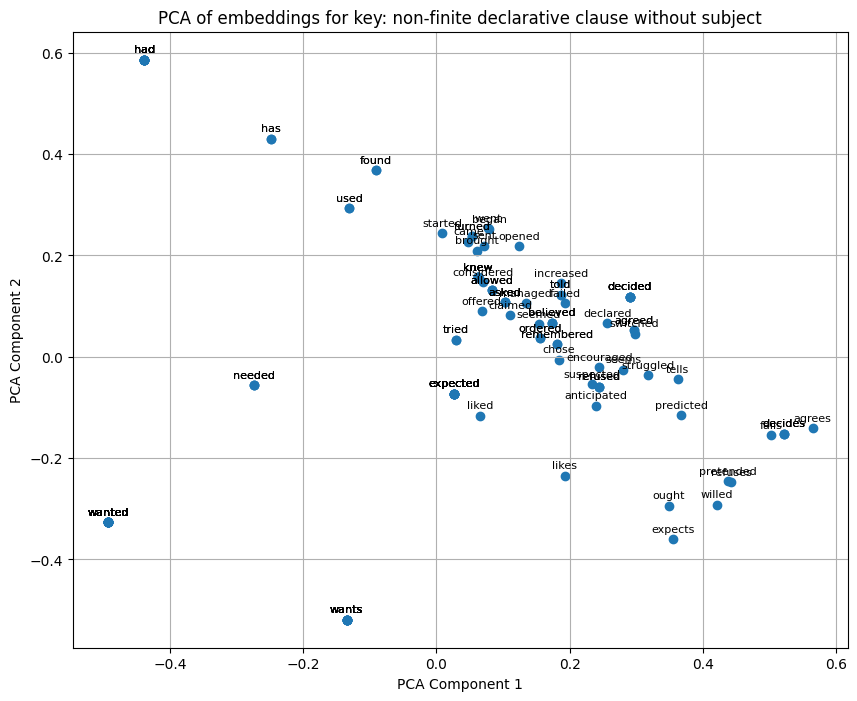

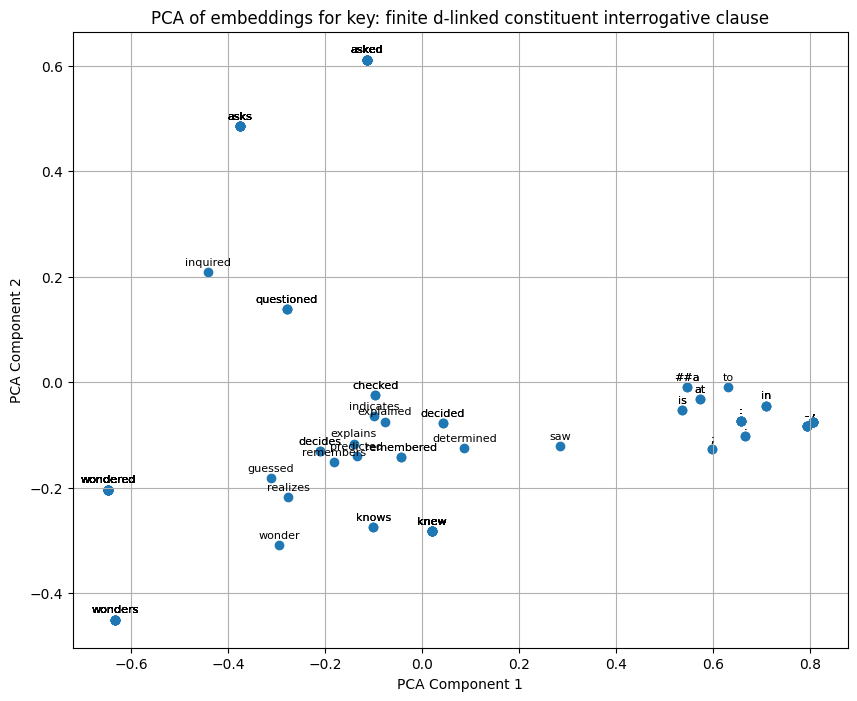

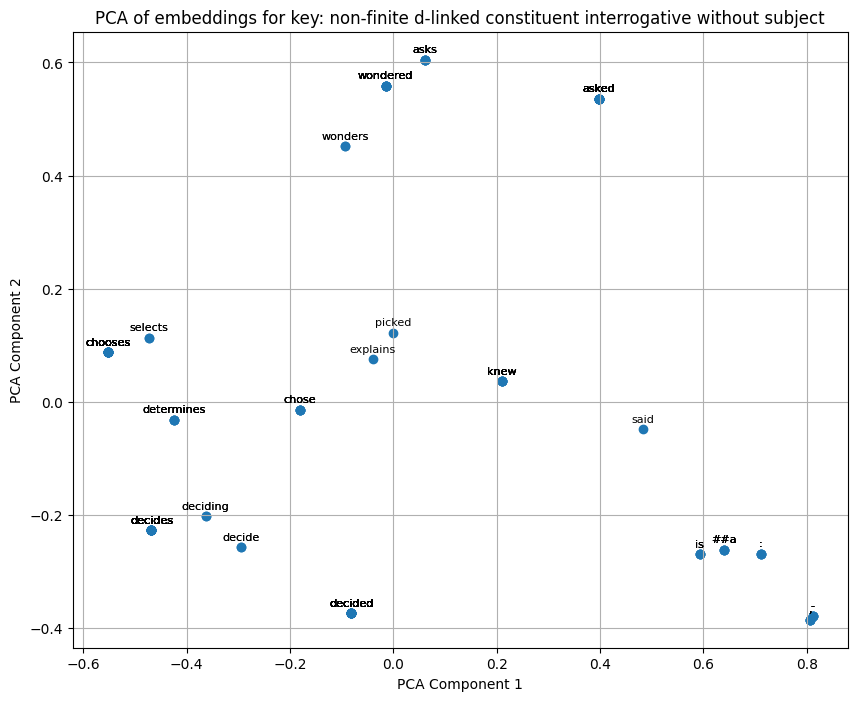

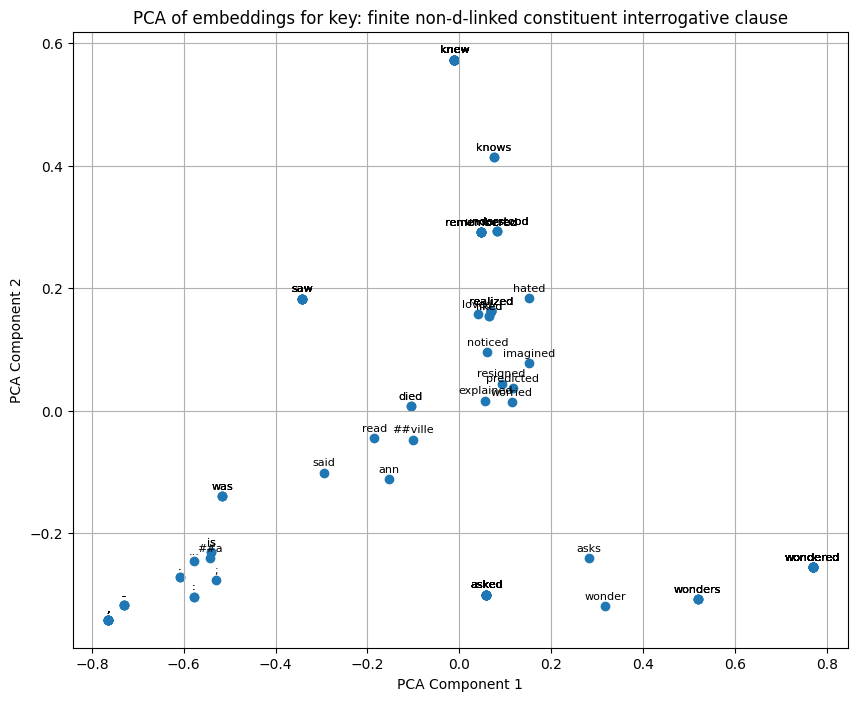

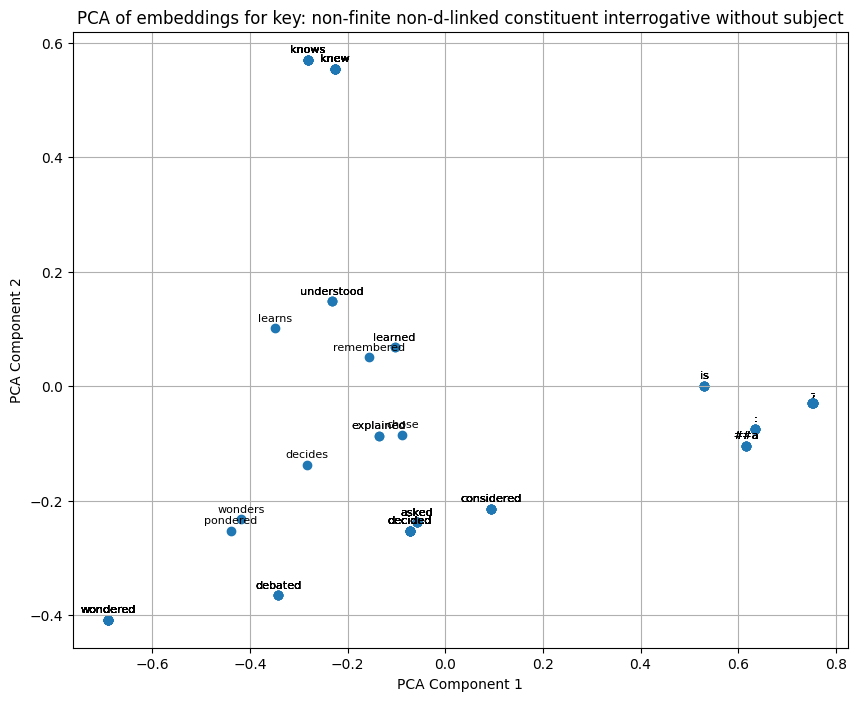

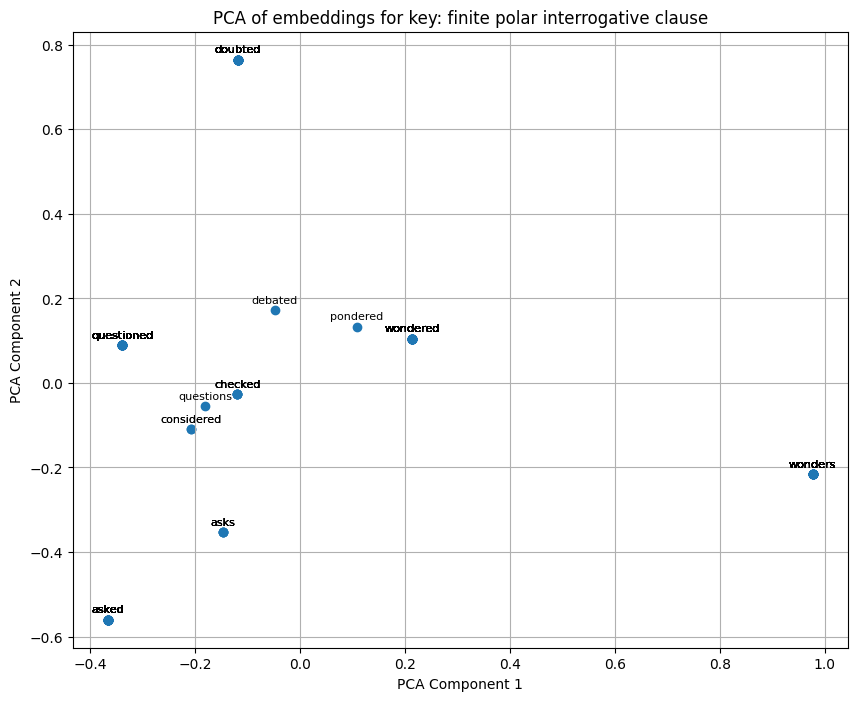

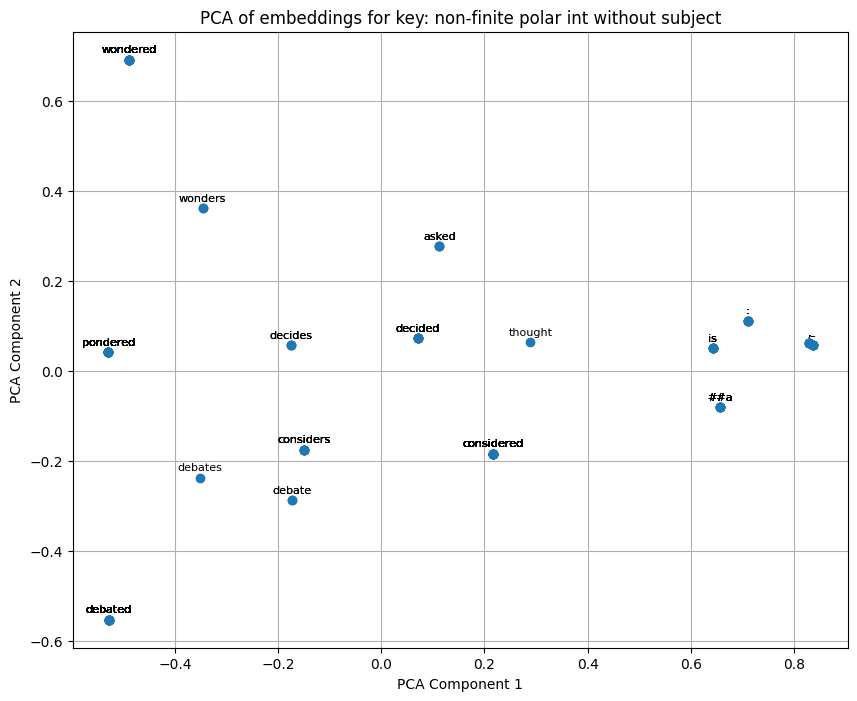

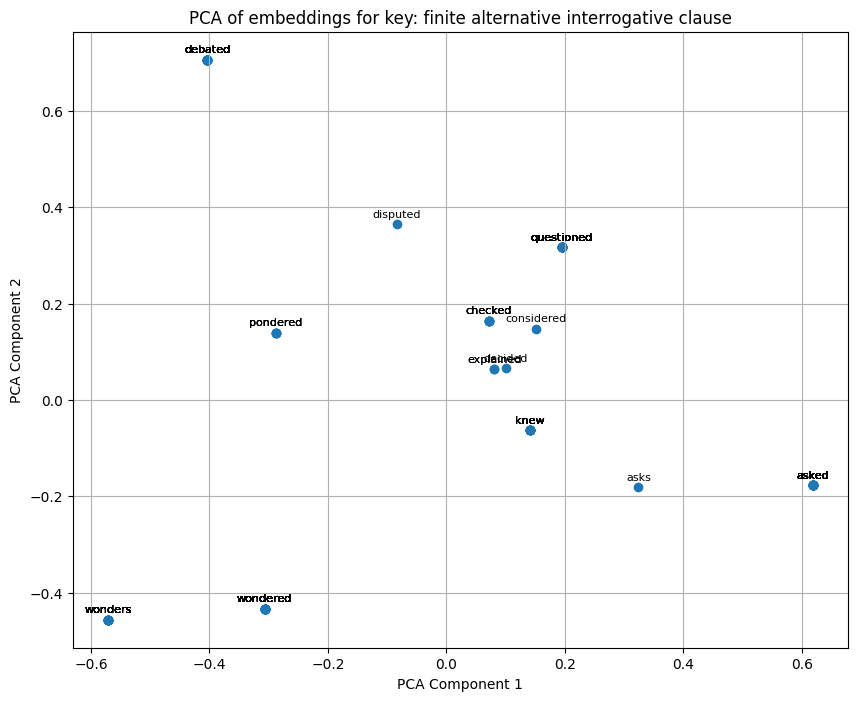

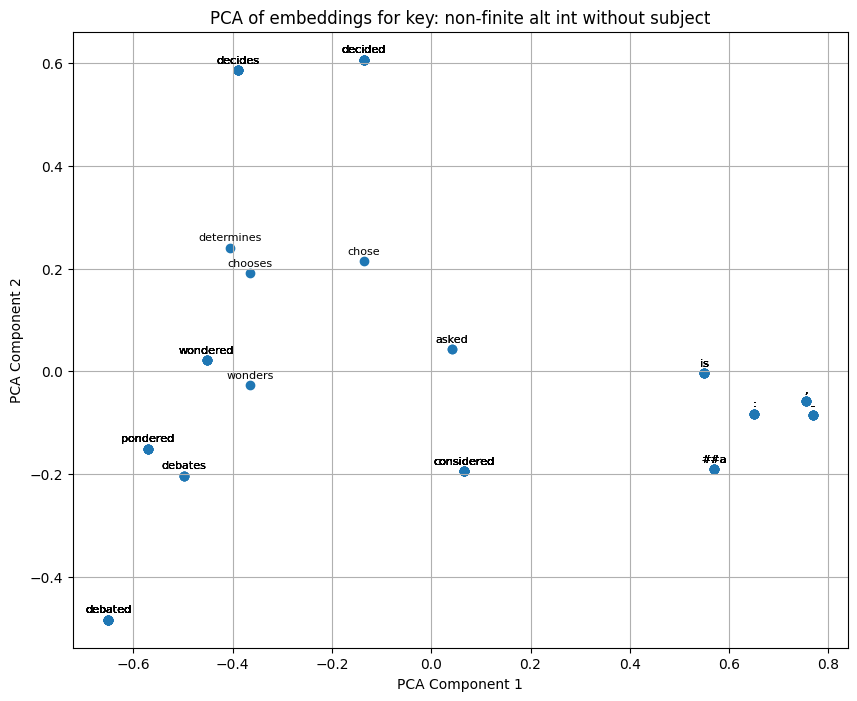

In [11]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# some more gpt tomfoolery

def plot_pca_for_predictions(pred_dict, embeddings_pred_dict):
    import torch
    import numpy as np

    for key in pred_dict.keys():
        tokens = pred_dict[key]               # list of tokens, length = num_masked_tokens * top_k
        embeddings = embeddings_pred_dict[key]  # likely list of tensors, each (top_k, hidden_dim)

        # Convert list of tensors to one tensor (num_masked_tokens, top_k, hidden_dim)
        if isinstance(embeddings, list):
            embeddings = torch.stack(embeddings)  # shape: (num_masked_tokens, top_k, hidden_dim)

        # Flatten to (num_masked_tokens * top_k, hidden_dim)
        num_masked_tokens, top_k, hidden_dim = embeddings.shape
        embeddings = embeddings.view(num_masked_tokens * top_k, hidden_dim)

        # Convert to numpy
        embeddings_np = embeddings.detach().cpu().numpy()

        # PCA
        pca = PCA(n_components=2)
        embeddings_2d = pca.fit_transform(embeddings_np)

        plt.figure(figsize=(10, 8))
        plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])

        # tokens list length must be num_masked_tokens * top_k
        if len(tokens) != num_masked_tokens * top_k:
            raise ValueError(f"Tokens length ({len(tokens)}) does not match embeddings shape ({num_masked_tokens * top_k})")

        for i, token in enumerate(tokens):
            plt.annotate(token, (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                         textcoords="offset points", xytext=(0,5), ha='center', fontsize=8)

        plt.title(f"PCA of embeddings for key: {key}")
        plt.xlabel("PCA Component 1")
        plt.ylabel("PCA Component 2")
        plt.grid(True)
        plt.show()



plot_pca_for_predictions(pred_dict, embeddings_pred_dict)

/tmp/ipykernel_13/906380771.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_keys))


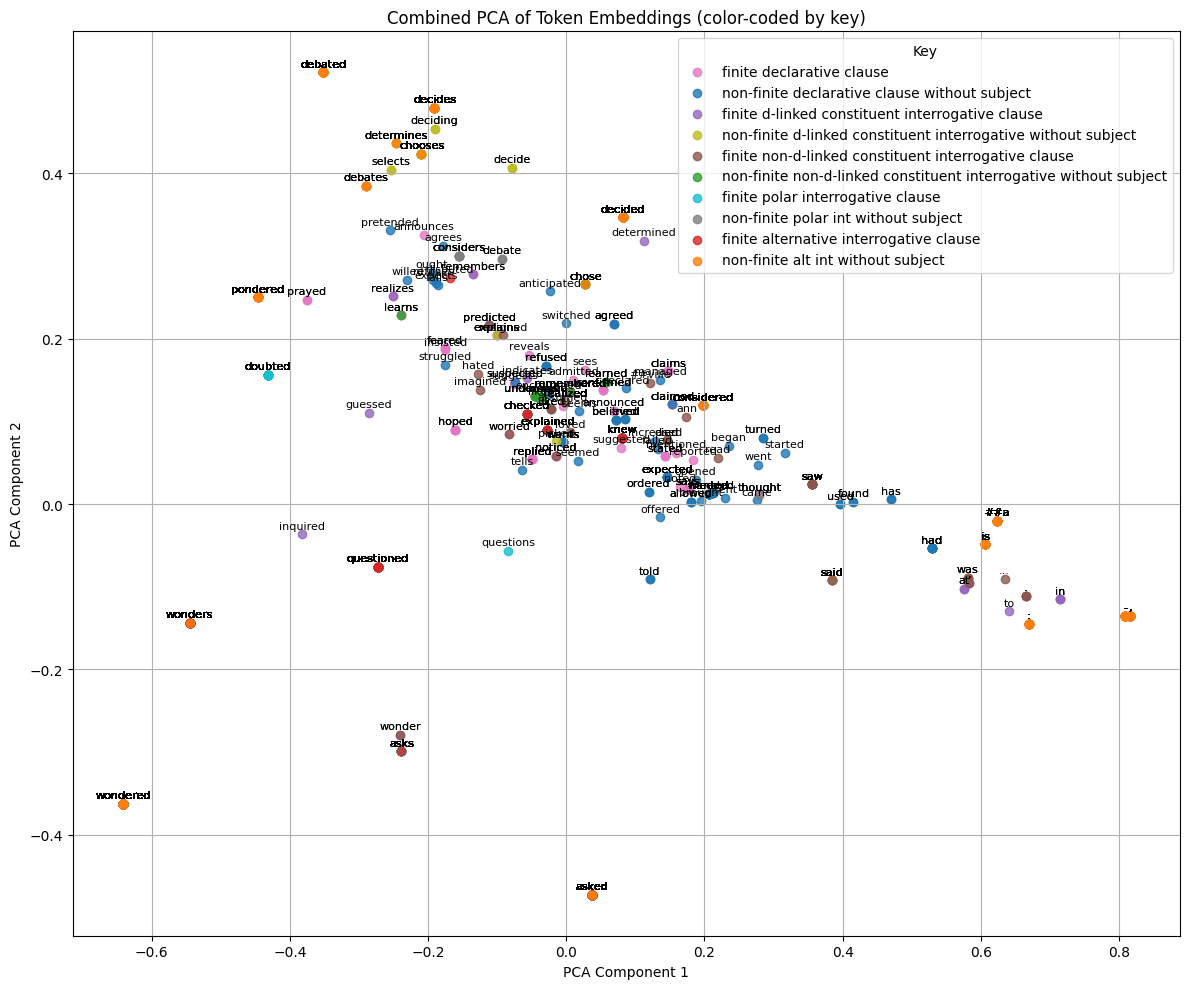

In [12]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch
import numpy as np

def plot_combined_pca(pred_dict, embeddings_pred_dict):
    all_embeddings = []
    all_labels = []
    all_tokens = []

    for key in pred_dict.keys():
        tokens = pred_dict[key]               # list of tokens
        embeddings = embeddings_pred_dict[key]  # list of tensors [top_k, hidden_dim]

        # Stack into a single tensor if it's a list of tensors
        if isinstance(embeddings, list):
            embeddings = torch.stack(embeddings)  # shape: (num_masked_tokens, top_k, hidden_dim)

        # Flatten to (num_masked_tokens * top_k, hidden_dim)
        embeddings = embeddings.view(-1, embeddings.shape[-1])  # [N, hidden_dim]

        all_embeddings.append(embeddings)
        all_labels.extend([key] * embeddings.shape[0])  # repeat key for each embedding
        all_tokens.extend(tokens)

    # Concatenate all embeddings into a single tensor
    all_embeddings = torch.cat(all_embeddings, dim=0).detach().cpu().numpy()

    # PCA to 2D
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(all_embeddings)

    # Plotting
    plt.figure(figsize=(12, 10))

    # Assign a unique color to each key
    unique_keys = list(set(all_labels))
    colors = plt.cm.get_cmap('tab10', len(unique_keys))
    key_to_color = {key: colors(i) for i, key in enumerate(unique_keys)}

    for i, (x, y) in enumerate(embeddings_2d):
        key = all_labels[i]
        plt.scatter(x, y, color=key_to_color[key], label=key if i == all_labels.index(key) else "", alpha=0.8)
        plt.annotate(all_tokens[i], (x, y), textcoords="offset points", xytext=(0, 4), ha='center', fontsize=8)

    # Unique legend entries
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), title="Key", loc="best")

    plt.title("Combined PCA of Token Embeddings (color-coded by key)")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_combined_pca(pred_dict, embeddings_pred_dict)

## Frequency

In [13]:

import matplotlib.pyplot as plt


#from nltk.stem import WordNetLemmatizer
#wnl = WordNetLemmatizer()
#wnl.lemmatize('ducks')


import nltk
#nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.corpus import wordnet

# Create WordNetLemmatizer object
wnl = WordNetLemmatizer()



def count_elements(word_list):
    #words = ' '.join(word_list)
    #print(words)
    token_list = [wnl.lemmatize(x, pos="v") for x in word_list]
    #token_list = [wnl.lemmatize(x) for x in word_list]
    #print(token_list)
    
    count_dict = {}
    for x in token_list:
        count_dict[x]= token_list.count(x)

    sorted_count_dict = dict(sorted(count_dict.items(), key=lambda item: item[1], reverse=True))
    #print(sorted_count_dict)
    return sorted_count_dict

print(wnl.lemmatize("hopped", pos="v"))
print(wnl.lemmatize("hoped", pos="v"))

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


hop
hop


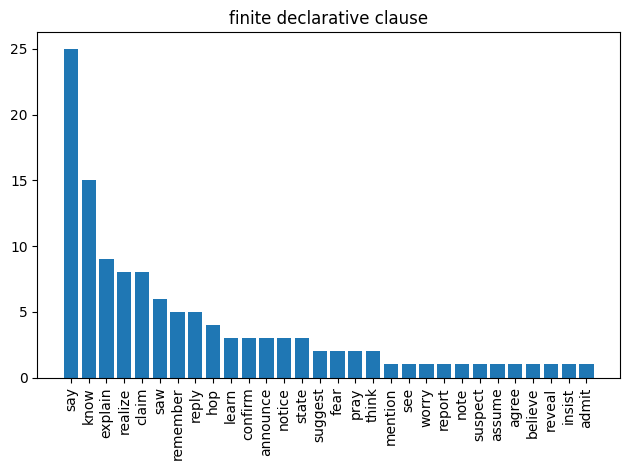

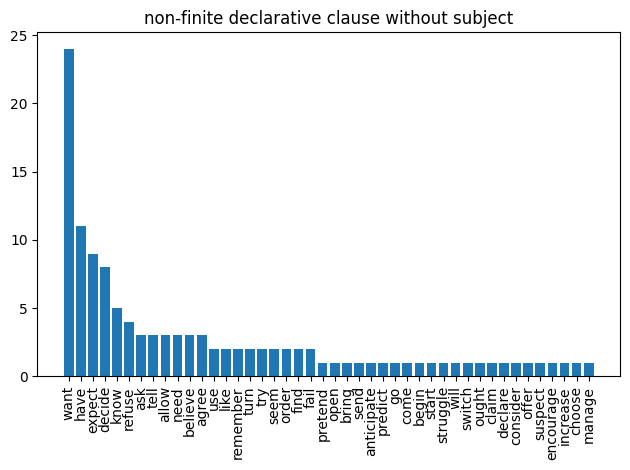

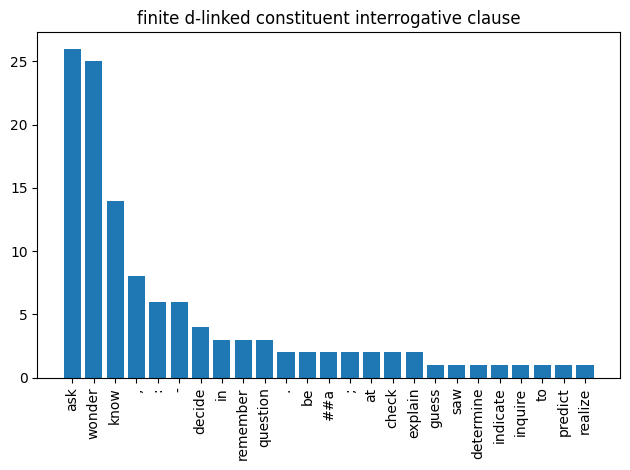

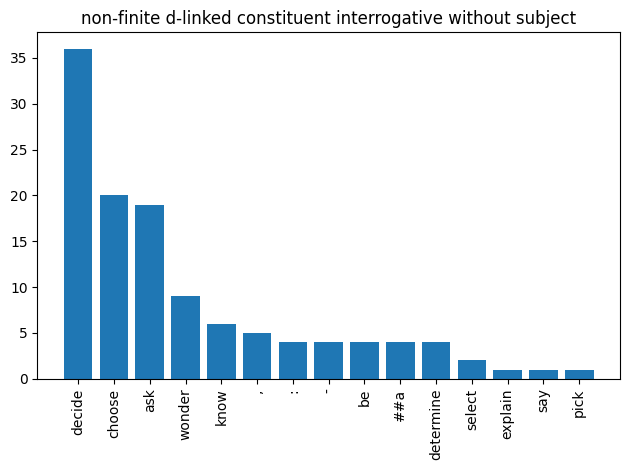

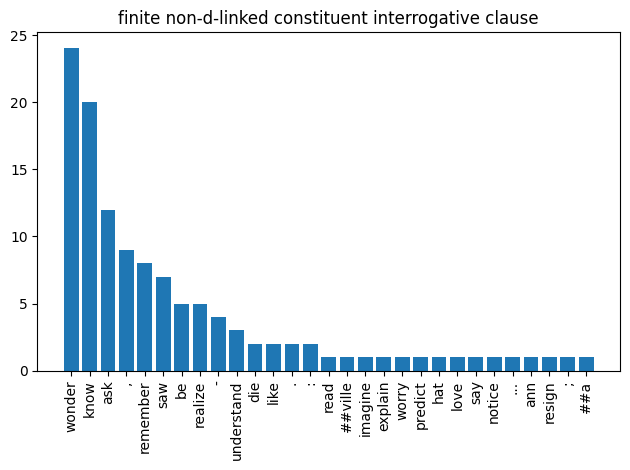

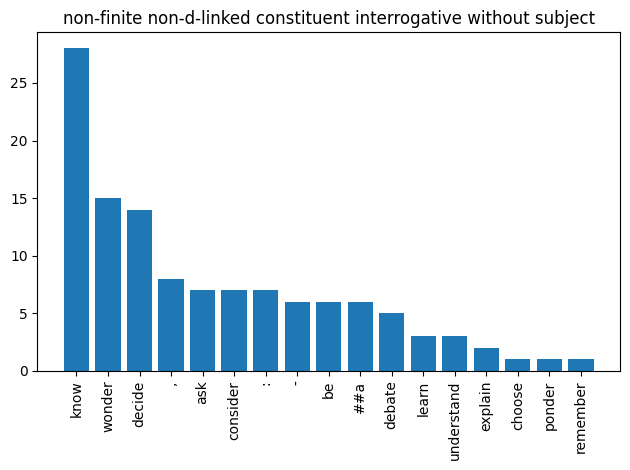

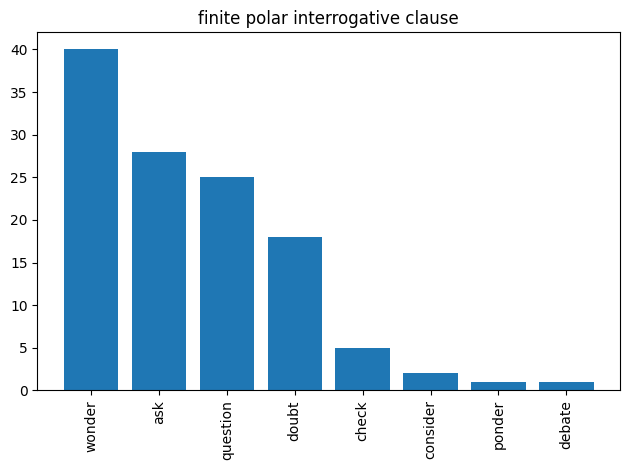

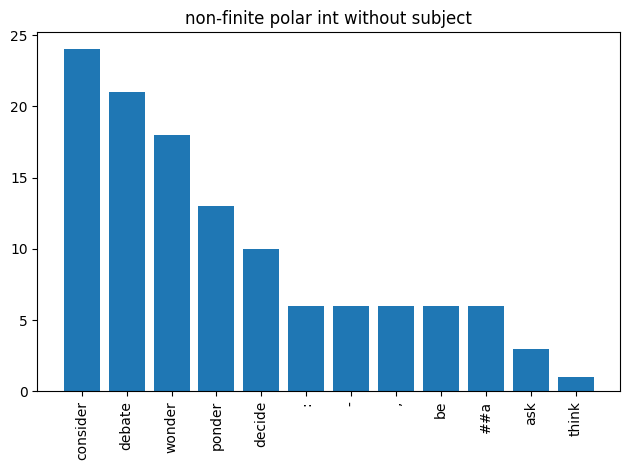

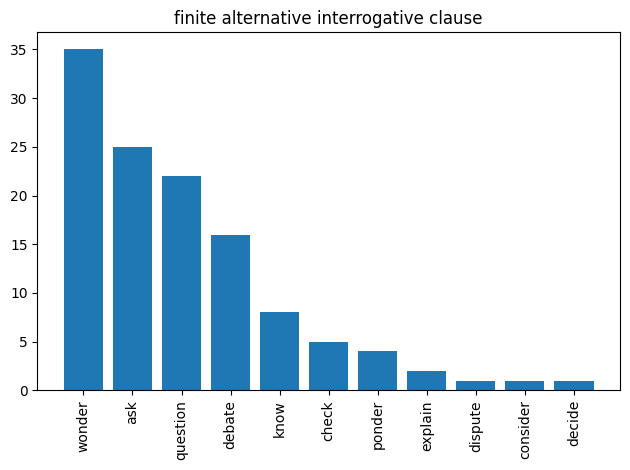

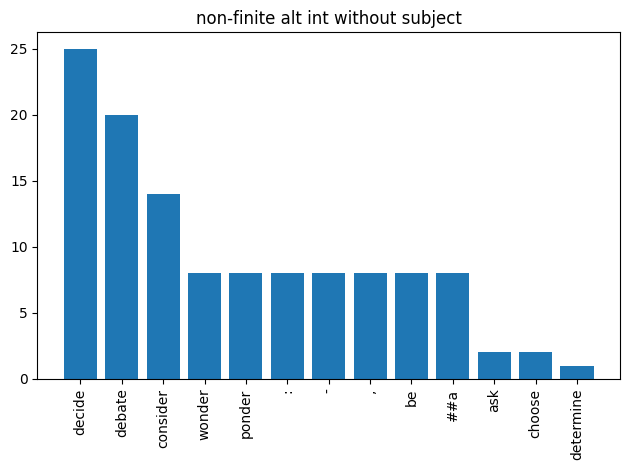

In [14]:
for key, listy in pred_dict.items():
    #plt.figure(figsize=(10, 10))
    count_elements(listy)
    list_count = count_elements(listy)
    #print(list_count)
    names = list(list_count.keys())
    values = list(list_count.values())
    plt.bar(range(len(list_count)), values, tick_label=names)
    plt.xticks(rotation=90) 
    plt.title(key)  # Optional: add title
    plt.tight_layout() 
    plt.show()
   # print()


# NSP

In [15]:
verbs = ["prefers", "wonders", "wants", "regrets", "believes", "hopes"]

# here, we would need judgements from MECORE

In [16]:
mecore_df = pd.read_csv("/kaggle/input/mecore-eng/2025-02-english-spreadsheet-v1.csv", index_col = "predicate")


#print(mecore_df)
#print(sent_type_dict.keys())


def get_verb_judgements(verb):
    #verb = verb.capitalize()
    verb = verb[:-1]
    #print(verb)
    judgement_dict = {}
    
    for key in sent_type_dict.keys():
        try:        
            judgement_dict[key] = mecore_df.loc[verb.capitalize()][key]
        except:
            print(key)
            #pass

    return judgement_dict


get_verb_judgements("hopes")
#Str = Str

{'finite declarative clause': 'acceptable',
 'non-finite declarative clause without subject': 'acceptable',
 'finite d-linked constituent interrogative clause': 'for required',
 'non-finite d-linked constituent interrogative without subject': 'for required',
 'finite non-d-linked constituent interrogative clause': 'for required',
 'non-finite non-d-linked constituent interrogative without subject': 'for required',
 'finite polar interrogative clause': 'unacceptable',
 'non-finite polar int without subject': 'unacceptable',
 'finite alternative interrogative clause': 'unacceptable',
 'non-finite alt int without subject': 'unacceptable'}

In [17]:
def create_nsp_pairs(sent_type_dict, verb):
    nlp_pair_dict = {}
    #print(sent_type_dict)
    for clause_type in sent_type_dict:
        nlp_pair_dict[clause_type] = [(f"Mary {verb}", x) for x in sent_type_dict[clause_type]]

    return nlp_pair_dict
    

In [18]:

def nsp_prob(verb):
    nsp_pair_clause = create_nsp_pairs(sent_type_dict, verb)

    target_acceptability = get_verb_judgements(verb)
    #print(target_acceptability)

    results = []

    for key, nsp_pairs, in nsp_pair_clause.items():
        all_is_next = 0
        for sent_a, sent_b in nsp_pairs:
            inputs = tokenizer(sent_a, sent_b, return_tensors="pt", padding=True, truncation=True)
    
            with torch.no_grad():
                outputs = model(**inputs)
                nsp_logits = outputs.seq_relationship_logits
                probs = torch.softmax(nsp_logits, dim=1)
        
            is_next_prob = probs[0][0].item()
            not_next_prob = probs[0][1].item()
    
            
            all_is_next += is_next_prob

        average_prob = round(all_is_next/len(nsp_pairs), 4)

        predicted_value = round(all_is_next/len(nsp_pairs))
        
        results.append({
            'key': key,
            'average_nsp_prob': average_prob,
            'predicted_value': predicted_value,
            'judgement_value': target_acceptability.get(key, None)
        })

        results_df = pd.DataFrame(results)

    return results_df
       
        #print(f"{key}: {average_prob * 100} %")
    

In [19]:
for verb in verbs:
    print(f"Probability that a Clause Type can follow '{verb}':")
    results_df = nsp_prob(verb)
    print(results_df)

Probability that a Clause Type can follow 'prefers':
                                                 key  average_nsp_prob  \
0                          finite declarative clause            0.5590   
1      non-finite declarative clause without subject            0.8996   
2   finite d-linked constituent interrogative clause            0.6360   
3  non-finite d-linked constituent interrogative ...            0.8594   
4  finite non-d-linked constituent interrogative ...            0.7374   
5  non-finite non-d-linked constituent interrogat...            0.9478   
6                  finite polar interrogative clause            0.3418   
7               non-finite polar int without subject            0.9216   
8            finite alternative interrogative clause            0.3413   
9                 non-finite alt int without subject            0.8986   

   predicted_value judgement_value  
0                1      acceptable  
1                1      acceptable  
2                1   

In [20]:
#GPT NSP


nsp_pairs = [
    ("The sun rises", "in the east."),  # is next
    ("The sun rises", "in the west."),
    ("Apples are red.", "Cars can be expensive."),           # not next
    ("Apples are red.", "The man is on the helicopter."), 
    ("Water appears", "happening"),
    ("Water appears", "boiling"),
    ("Water appears", "to be boiling"),
]


for sent_a, sent_b in nsp_pairs:
    inputs = tokenizer(sent_a, sent_b, return_tensors="pt", padding=True, truncation=True)

    with torch.no_grad():
        outputs = model(**inputs)
        nsp_logits = outputs.seq_relationship_logits
        probs = torch.softmax(nsp_logits, dim=1)

    is_next_prob = probs[0][0].item()
    not_next_prob = probs[0][1].item()
    print(f"A: {sent_a}")
    print(f"B: {sent_b}")
    print(f"Is Next: {is_next_prob:.4f}, Not Next: {not_next_prob:.4f}\n")


A: The sun rises
B: in the east.
Is Next: 1.0000, Not Next: 0.0000

A: The sun rises
B: in the west.
Is Next: 1.0000, Not Next: 0.0000

A: Apples are red.
B: Cars can be expensive.
Is Next: 0.9992, Not Next: 0.0008

A: Apples are red.
B: The man is on the helicopter.
Is Next: 0.9964, Not Next: 0.0036

A: Water appears
B: happening
Is Next: 0.9982, Not Next: 0.0018

A: Water appears
B: boiling
Is Next: 0.9998, Not Next: 0.0002

A: Water appears
B: to be boiling
Is Next: 1.0000, Not Next: 0.0000

